# Analyzes the PCs for the different data sets

In [3]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.decomposition import PCA,FastICA,KernelPCA
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split

In [4]:
def analysePCA(X,y,n_components,cols_to_drop, column_to_analyze='Cond',transformation=False,transformedFeatures=None):
    from sklearn.model_selection import train_test_split
    
    # split the data into train test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,shuffle=True)     
    
    
    scaler = StandardScaler()
    if transformation==False:
        columns = X_train.drop(cols_to_drop,axis=1).columns
        columns=np.array(columns)
        
        scaler.fit(X_train.drop(cols_to_drop,axis=1))
        X_train_sc=scaler.transform(X_train.drop(cols_to_drop,axis=1))
        X_test_sc = scaler.transform(X_test.drop(cols_to_drop,axis=1))
        title='Projecting original features in PC dimensions'
    else:
        # drop user_id, sessionNr, cond,App
        # select only normal features
        X_train_temp = X_train.drop(cols_to_drop,axis=1)[transformedFeatures]
        X_test_temp=X_test.drop(cols_to_drop,axis=1)[transformedFeatures]
        print(X_train_temp.shape)
        
        print("Shape after selecting only transformed features ",X_train_temp.shape)
        scaler.fit(X_train_temp)
        X_train_sc=scaler.transform(X_train_temp)
        X_test_sc = scaler.transform(X_test_temp)
        
        columns = transformedFeatures
        columns=np.array(columns)
        title='Projecting transformed features in PC dimensions'

    pca= PCA(n_components=n_components)
    pca.fit(X_train_sc)
    print('number of principal components:',pca.n_components_)
    # logging.info('number of principal components: {}'.format(pca.n_components_))
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_train_sc)
    print(X_train_pca.shape)

    # explains the noise variance
    print('Noise Variance:{}'.format(pca.noise_variance_))

    #explains how much variance is captured by each PC. 
    var = pca.explained_variance_ratio_
    # Cumulative variance
    var_cum=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
    print(len(var))
    print('Number of prinicipal components generated for spell:',pca.n_components_)

    #append the result in data frame
    data_spell={'Proportion of Variance Explained':np.round(var,decimals=4),'Cummulative Variance Explained':var_cum,
              'Principal Components':np.arange(1,pca.n_components_+1),
                    'eigenvalues':pca.explained_variance_}
    df_variance_spell = pd.DataFrame(data=data_spell)

    print(var_cum)

    # plot the results
    '''
    Plot the first and second PCs based on column provided
    '''
    fig, (ax1,ax2)=plt.subplots(1,2, figsize=(15,8))
    X_train_pca = pd.DataFrame(X_train_pca)
    cond=X_train[column_to_analyze]
    cond=cond.reset_index(drop=True)
    data =pd.concat([X_train_pca,cond],axis=1)
    sns.scatterplot(x=0,y=1,hue=column_to_analyze,data=data,ax=ax1)
    ax1.set_xlabel('PC1 with {0:.2f}% variance'.format(pca.explained_variance_ratio_[0]*100))
    ax1.set_ylabel('PC2 with {0:.2f}% variance'.format(pca.explained_variance_ratio_[1]*100))
    ax1.set_title(title)

    '''
    Plot the variance explained by the PCs
    '''
    ax2.plot(df_variance_spell['Principal Components'],
                 df_variance_spell['Proportion of Variance Explained'],label='variance',color='blue',linestyle='dashed')
    ax2.plot(df_variance_spell['Principal Components'],
                 df_variance_spell['Cummulative Variance Explained'],label='cummulative variance',
                color='orange')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Variance Explained')

    ax2.set_title('Variance explained by each PC')
    ax2.legend()

    '''
    features contribution by sort the mean in descending order
    '''
    contrib_features_mean = pca.components_.mean(axis=0)
    contrib_features_std=np.square(pca.components_.std(axis=0))

    sort_indices = np.argsort(contrib_features_mean)[::-1]
    print(len(sort_indices))
    contrib_features_mean[:] = contrib_features_mean[sort_indices]
    contrib_features_std[:] = contrib_features_std[sort_indices]
    columns[:]=columns[sort_indices]
#     print("Columns sorted according to the weights in PCs: ",columns)
    
    # store the mean and std in one file with two seperate tabs
   

    fig,axs = plt.subplots(1,1,figsize=(15, 8),sharex=True)
    axs.plot(contrib_features_mean, '--o', label = 'mean')
    axs.plot(contrib_features_std, '--o', label = 'variance')
    axs.legend(loc='lower right')
    axs.set_ylabel('Feature Contribution')
    axs.set_xticks(np.arange(len(columns)))
    axs.set_xlim([0, 40])
    axs.set_xticklabels(columns,rotation=90)
    axs.set_title('Original distributions')
    fig.suptitle('Feature contributions over all the PC',fontsize=15)

number of principal components: 35
(130, 35)
Noise Variance:0.09354405414231484
35
Number of prinicipal components generated for spell: 35
[0.2925 0.4135 0.5062 0.5629 0.6012 0.632  0.6581 0.6827 0.7066 0.7274
 0.745  0.7617 0.777  0.7913 0.8052 0.8184 0.8308 0.8428 0.8526 0.862
 0.8708 0.8791 0.8871 0.8942 0.9008 0.9073 0.9137 0.9198 0.925  0.9298
 0.9345 0.9389 0.9431 0.947  0.9507]
181


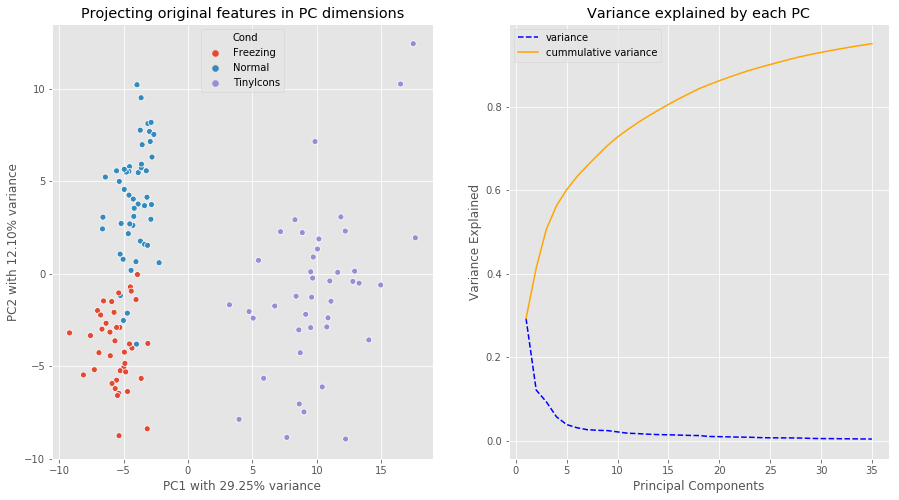

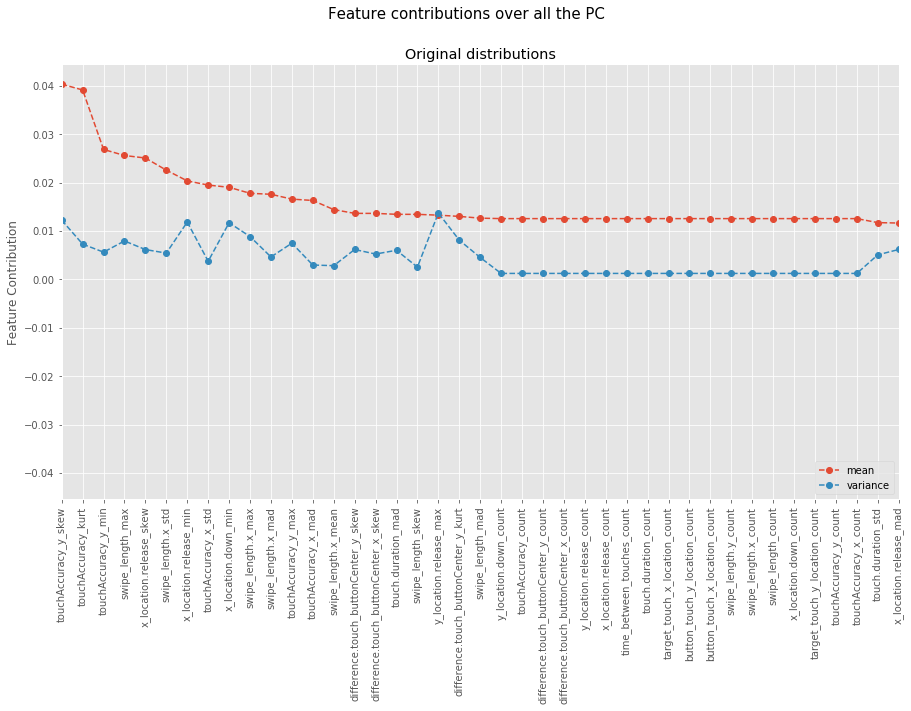

In [3]:
'''
find whether pcs have relation with cond for study1 on original distributions with 0.95 variance explained
'''
path='../datasets/files_generated/UX/study1_features_data_out_mahalanobis.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['SEA', 'PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]
n_components=0.95
transformation=False
cols_to_drop=['user_id','App','Cond','sessionNr']
column_to_analyze='Cond'
analysePCA(X,y,n_components,cols_to_drop,column_to_analyze, transformation=transformation)

number of principal components: 34
(130, 34)
Noise Variance:0.07684624375073469
34
Number of prinicipal components generated for spell: 34
[0.2373 0.3607 0.4535 0.5146 0.551  0.5853 0.6176 0.6464 0.6734 0.6952
 0.7156 0.7352 0.7536 0.7706 0.7871 0.802  0.8167 0.8294 0.8416 0.853
 0.8639 0.8738 0.8828 0.8916 0.8996 0.9073 0.9143 0.9209 0.9271 0.9331
 0.9387 0.9439 0.9485 0.9529]
89


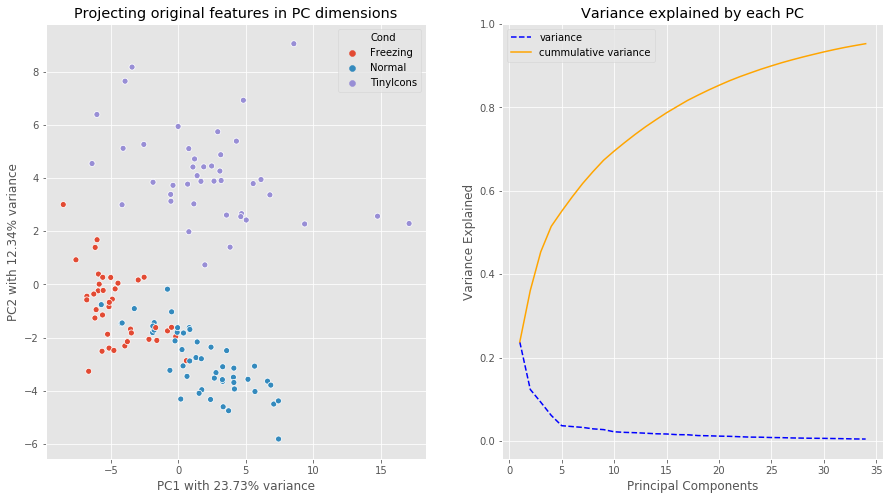

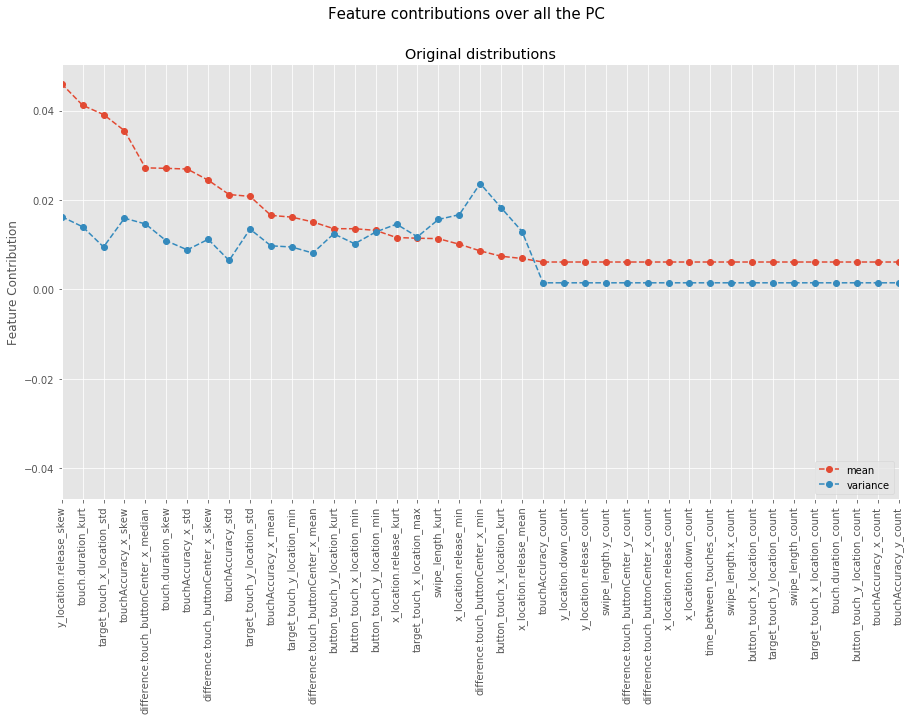

In [19]:
'''
find whether pcs have relation with cond for study1 on original distributions with 0.95 variance explained
removing 0 variance and also highly correlated variables
'''
path='../datasets/files_generated/UX/study1_features_data_out_mahalanobis.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['SEA', 'PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]

# remove 0 variance
zero_var_cols = X.select_dtypes(['float64']).loc[:, X.var() == 0.0].columns
X = X.drop(X[zero_var_cols],axis=1)
# Create correlation matrix
corr_matrix = X.select_dtypes(['float64']).corr().abs()

# Select upper triangle of correlation matrix
upper_traingle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop_cols = [column for column in upper_traingle.columns if any(upper_traingle[column] >= 0.80)]

# Drop features 
X = X.drop(X[to_drop_cols], axis=1)
n_components=0.95
transformation=False
cols_to_drop=['user_id','App','Cond','sessionNr']
column_to_analyze='Cond'
analysePCA(X,y,n_components,cols_to_drop,column_to_analyze, transformation=transformation)

number of principal components: 15
(130, 15)
Noise Variance:0.3056286634586612
15
Number of prinicipal components generated for spell: 15
[0.2925 0.4135 0.5062 0.5629 0.6012 0.632  0.6581 0.6827 0.7066 0.7274
 0.745  0.7617 0.777  0.7913 0.8052]
181


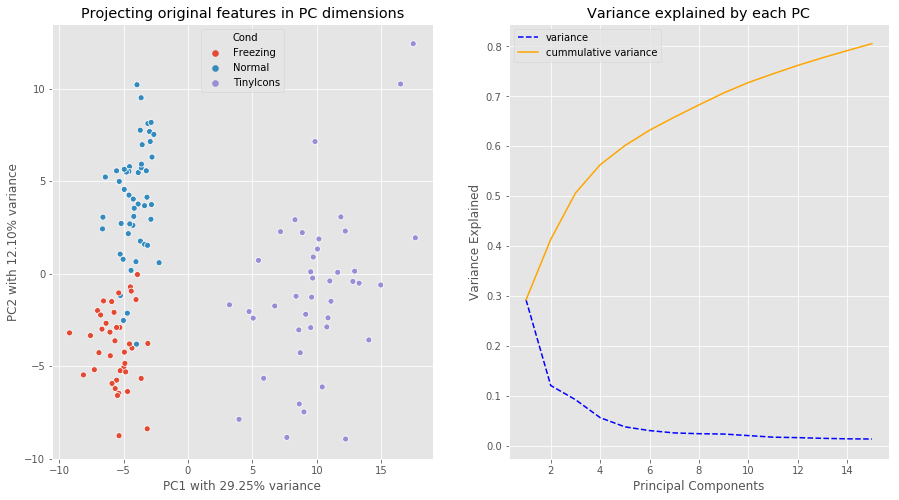

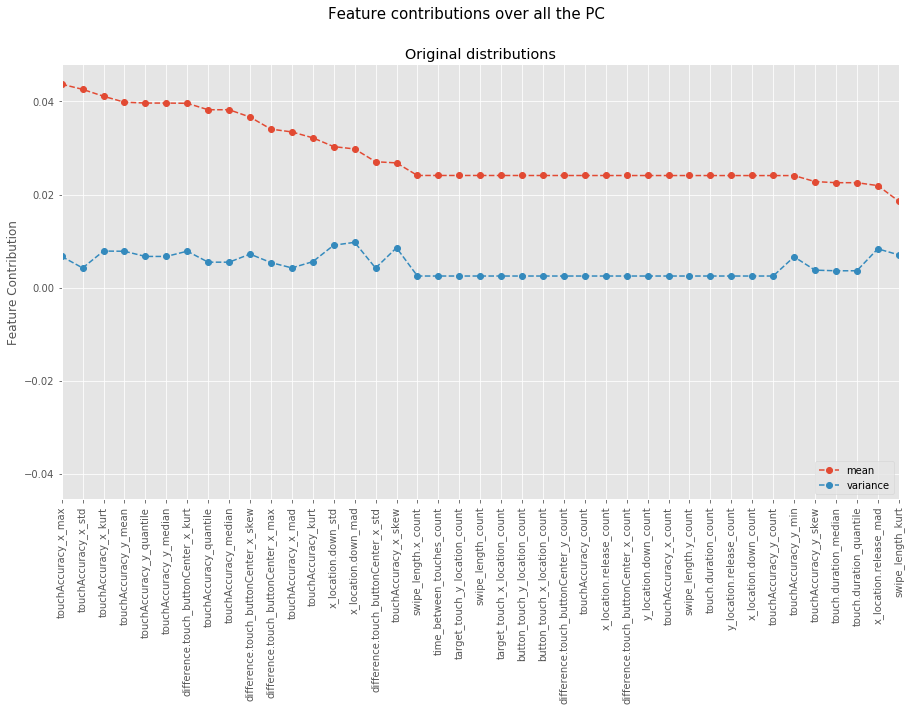

In [4]:
'''
find whether pcs have relation with cond for study1 on original distributions with 0.80 variance explained
'''
path='../datasets/files_generated/UX/study1_features_data_out_mahalanobis.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['SEA', 'PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]
n_components=0.80
transformation=False
cols_to_drop=['user_id','App','Cond','sessionNr']
column_to_analyze='Cond'
analysePCA(X,y,n_components,cols_to_drop,column_to_analyze, transformation=transformation)

number of principal components: 3
(130, 3)
Noise Variance:0.7012460867891132
3
Number of prinicipal components generated for spell: 3
[0.2925 0.4135 0.5062]
181


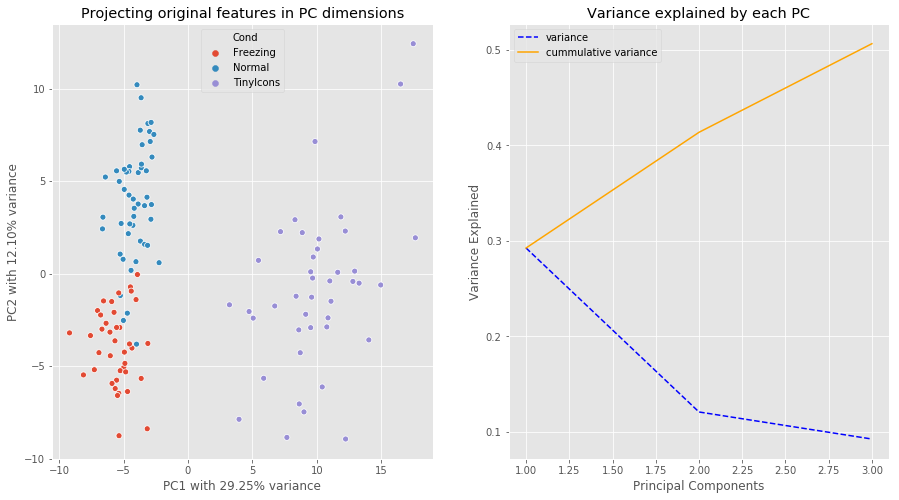

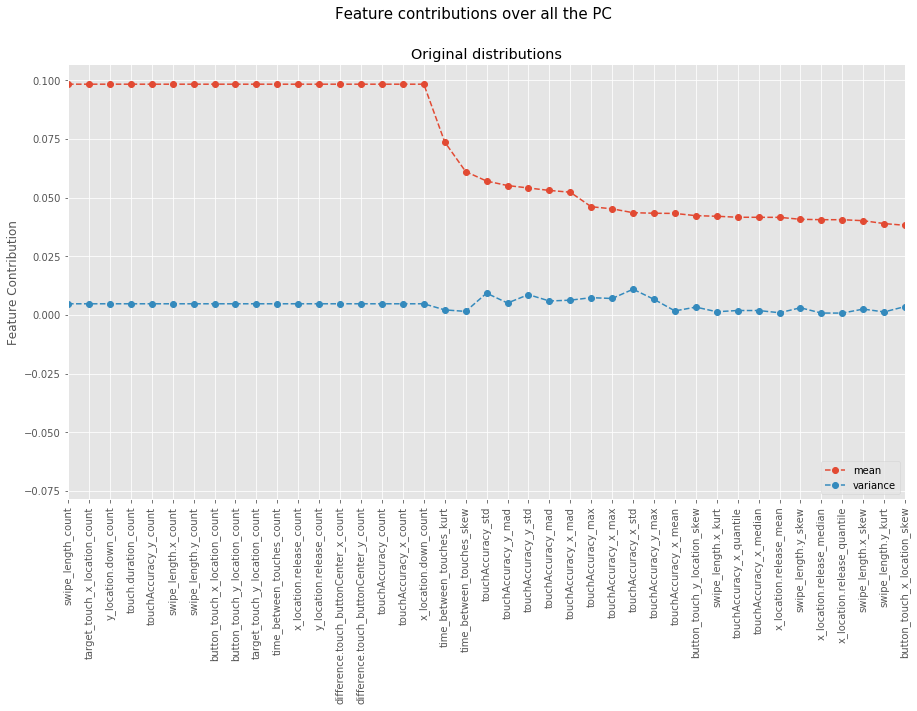

In [5]:
'''
find whether pcs have relation with cond for study1 on original distributions with 3 PCs
'''
path='../datasets/files_generated/UX/study1_features_data_out_mahalanobis.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['SEA', 'PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]
n_components=3
transformation=False
cols_to_drop=['user_id','App','Cond','sessionNr']
column_to_analyze='Cond'
analysePCA(X,y,n_components,cols_to_drop,column_to_analyze, transformation=transformation)

number of principal components: 47
(410, 47)
Noise Variance:0.06619516640552833
47
Number of prinicipal components generated for spell: 47
[0.2535 0.354  0.409  0.4579 0.5002 0.5347 0.5679 0.5968 0.6209 0.6429
 0.6631 0.6813 0.698  0.7139 0.7293 0.7433 0.7559 0.7683 0.7805 0.7922
 0.8033 0.8141 0.8238 0.833  0.8418 0.8503 0.8584 0.8659 0.8728 0.8794
 0.8859 0.8921 0.8974 0.9025 0.9075 0.9122 0.9167 0.9209 0.9249 0.9288
 0.9324 0.936  0.9393 0.9425 0.9455 0.9483 0.951 ]
181


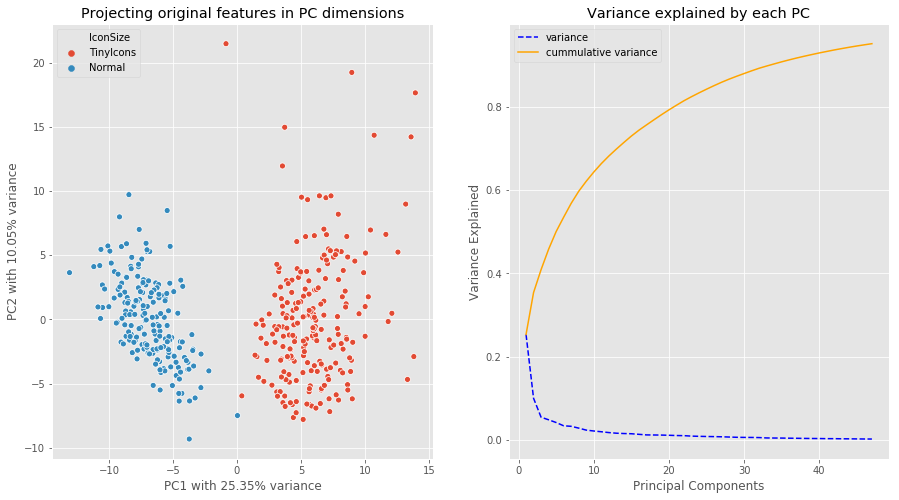

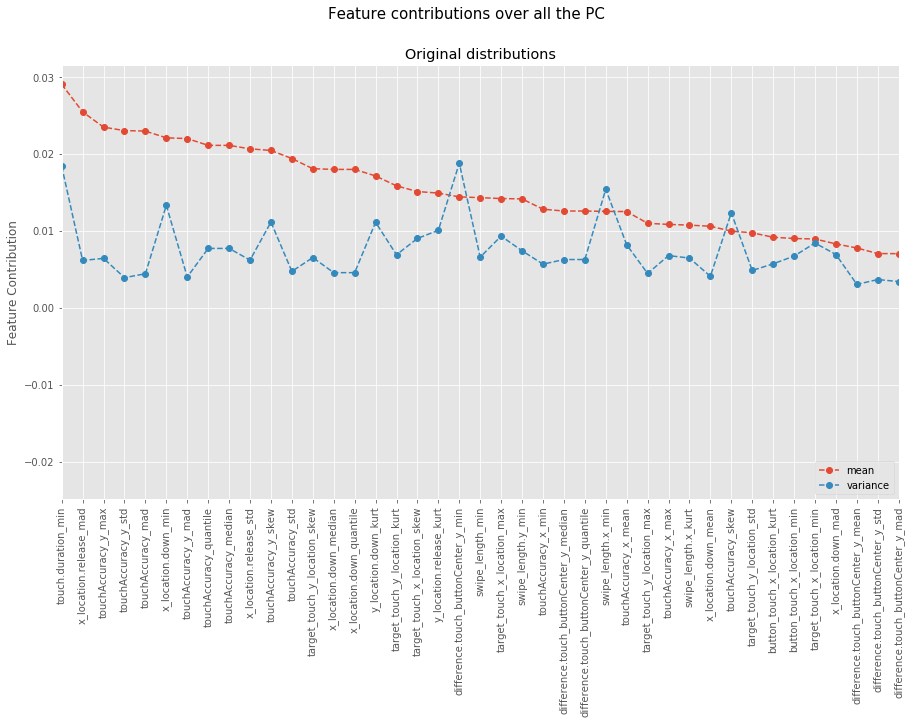

In [6]:
'''
find whether pcs have relation with cond for study2 on original distributions with 95% variance explained
'''

'''
find whether pcs have relation with cond for study1 on original distributions
'''
path='../datasets/files_generated/UX/study2_features_data_out_mahalanobis.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]
n_components=0.95
transformation=False
cols_to_drop=['sessionNr','App','user_id','Size','UserId', 'Session','IconSize','Unnamed: 25']
column_to_analyze='IconSize'
analysePCA(X,y,n_components,cols_to_drop, column_to_analyze,transformation=transformation)

number of principal components: 43
(410, 43)
Noise Variance:0.08583097478818212
43
Number of prinicipal components generated for spell: 43
[0.229  0.3214 0.3765 0.4242 0.4629 0.4987 0.5279 0.5565 0.5823 0.6067
 0.6296 0.6502 0.6705 0.6889 0.7068 0.7235 0.7392 0.7539 0.7673 0.7804
 0.7933 0.8057 0.818  0.8289 0.8388 0.8483 0.8575 0.8665 0.8749 0.8825
 0.8899 0.897  0.9035 0.9097 0.9155 0.921  0.9262 0.9311 0.9355 0.9398
 0.9439 0.9477 0.9513]
99


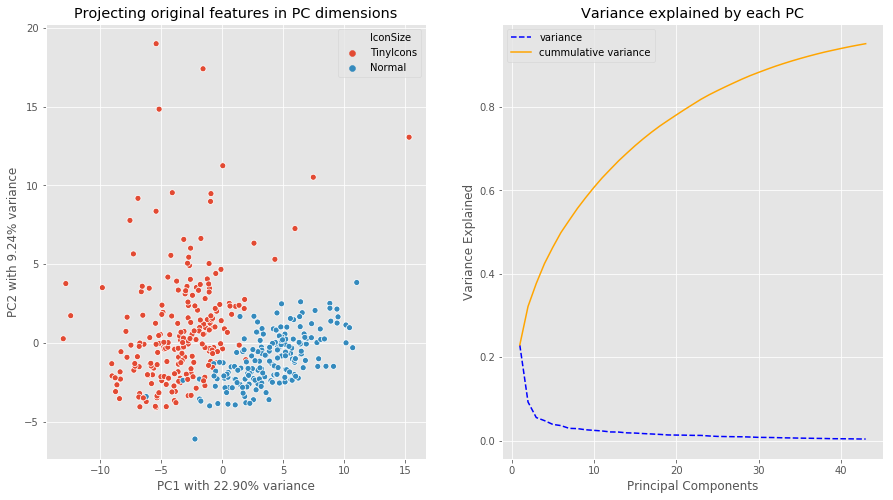

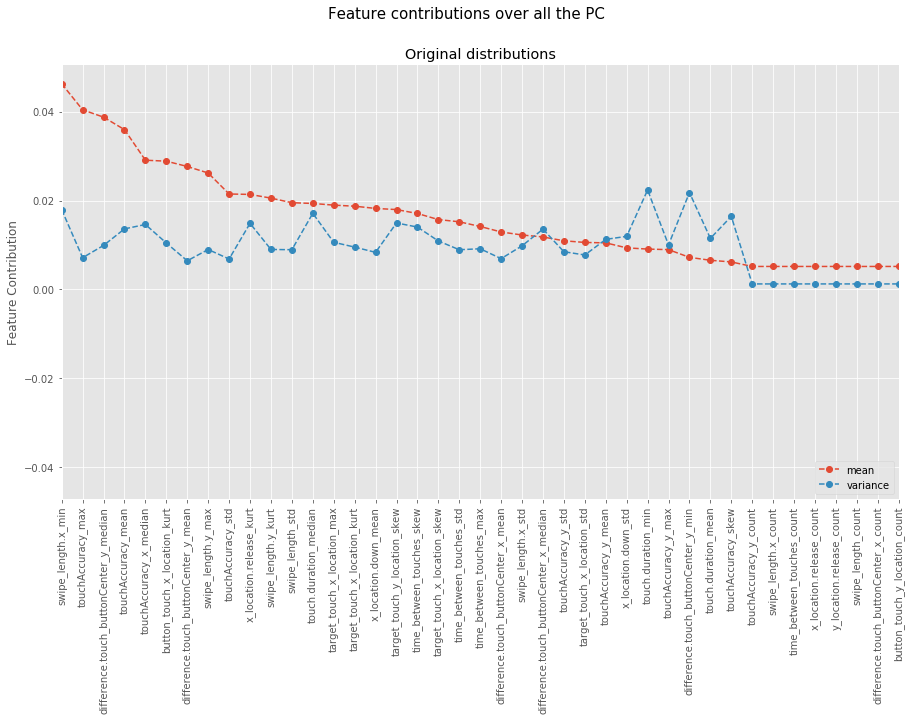

In [17]:

'''
find whether pcs have relation with cond for study2 on original distributions with 0.95 variance explained
removing 0 variance and also highly correlated variables
'''

path='../datasets/files_generated/UX/study2_features_data_out_mahalanobis.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]

# remove 0 variance
zero_var_cols = X.select_dtypes(['float64']).loc[:, X.var() == 0.0].columns
X = X.drop(X[zero_var_cols],axis=1)
# Create correlation matrix
corr_matrix = X.select_dtypes(['float64']).corr().abs()

# Select upper triangle of correlation matrix
upper_traingle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop_cols = [column for column in upper_traingle.columns if any(upper_traingle[column] >= 0.80)]

# Drop features 
X = X.drop(X[to_drop_cols], axis=1)


n_components=0.95
transformation=False
cols_to_drop=['sessionNr','App','user_id','Size','UserId', 'Session','IconSize']
column_to_analyze='IconSize'
analysePCA(X,y,n_components,cols_to_drop, column_to_analyze,transformation=transformation)


number of principal components: 21
(410, 21)
Noise Variance:0.22306288630105425
21
Number of prinicipal components generated for spell: 21
[0.2535 0.354  0.409  0.4579 0.5002 0.5347 0.5679 0.5968 0.6209 0.6429
 0.6631 0.6813 0.698  0.7139 0.7293 0.7433 0.7559 0.7683 0.7805 0.7922
 0.8033]
181


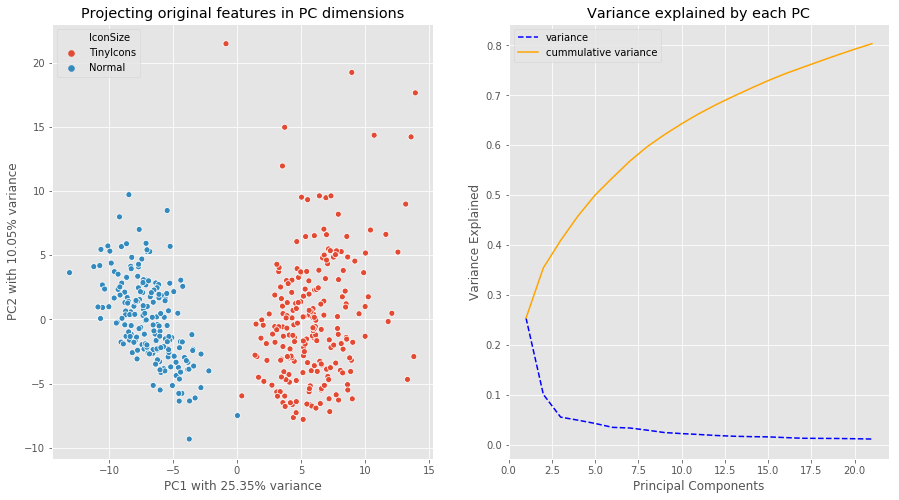

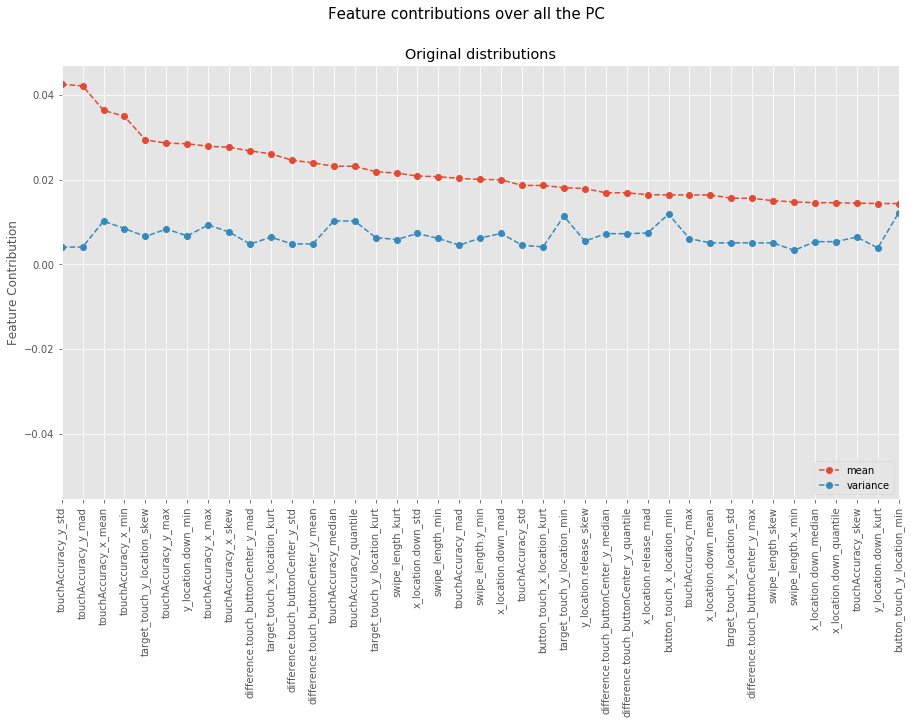

In [7]:
'''
find whether pcs have relation with cond for study2 on original distributions with 80% variance explained
'''

'''
find whether pcs have relation with cond for study1 on original distributions
'''
path='../datasets/files_generated/UX/study2_features_data_out_mahalanobis.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]
n_components=0.80
transformation=False
cols_to_drop=['sessionNr','App','user_id','Size','UserId', 'Session','IconSize','Unnamed: 25']
column_to_analyze='IconSize'
analysePCA(X,y,n_components,cols_to_drop, column_to_analyze,transformation=transformation)

161
157
selected columns are: ['x_location.down_mean', 'y_location.down_mean', 'touch.duration_mean', 'swipe_length_mean', 'swipe_length.x_mean', 'swipe_length.y_mean', 'button_touch_x_location_mean', 'button_touch_y_location_mean', 'target_touch_x_location_mean', 'target_touch_y_location_mean', 'time_between_touches_mean', 'x_location.release_mean', 'y_location.release_mean', 'difference.touch_buttonCenter_x_mean', 'difference.touch_buttonCenter_y_mean', 'touchAccuracy_mean', 'touchAccuracy_x_mean', 'touchAccuracy_y_mean', 'x_location.down_median', 'y_location.down_median', 'swipe_length_median', 'swipe_length.x_median', 'swipe_length.y_median', 'x_location.release_median', 'y_location.release_median', 'difference.touch_buttonCenter_x_median', 'difference.touch_buttonCenter_y_median', 'touchAccuracy_median', 'touchAccuracy_x_median', 'touchAccuracy_y_median', 'button_touch_x_location_skew', 'button_touch_y_location_skew', 'difference.touch_buttonCenter_x_skew', 'difference.touch_butto

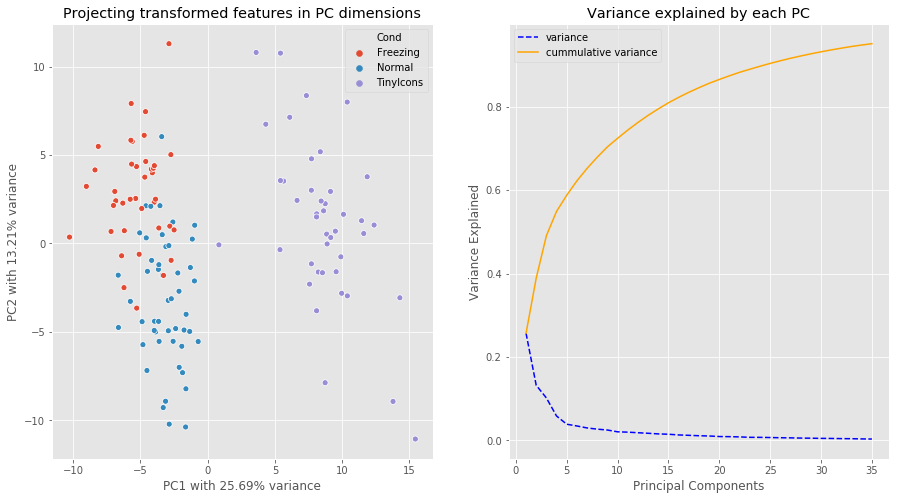

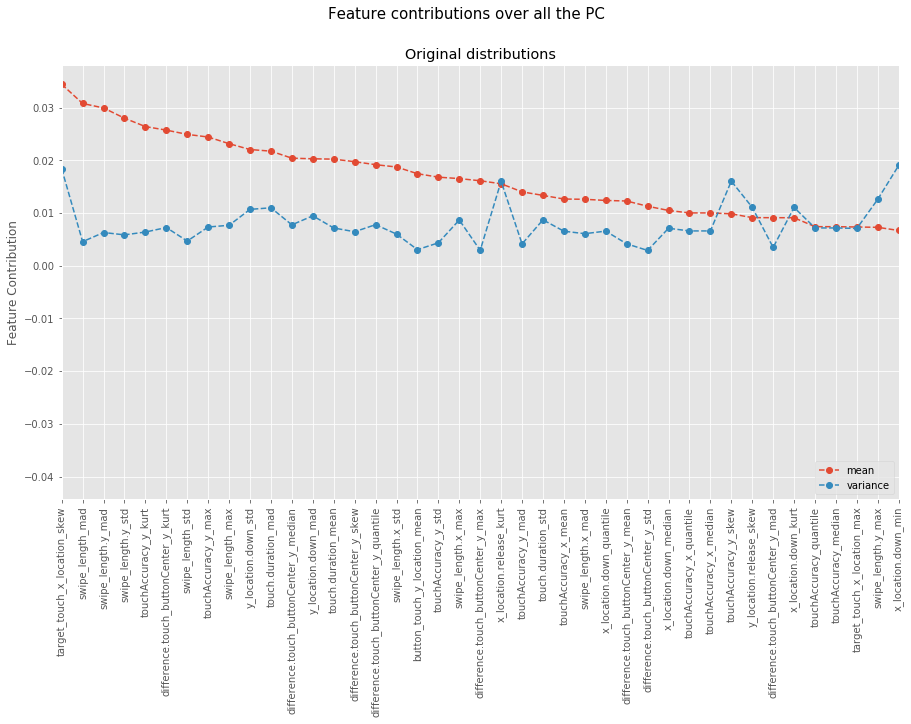

In [3]:
'''
find whether pcs have relation with cond for study1 on trnasformed distributions
'''

not_columns=['SEA','PQ','ATT', 'HQI', 'HQ','HQS']
mahalanobis = pd.read_csv('Tables/Study1/study1_univariate_normality_test_features_mahalanobis_transformed.csv')
mahalanobis = list(mahalanobis[mahalanobis['Normality']==True]['Features'].values)
print(len(mahalanobis))
for col in not_columns:
# # #     print(col)
    if(col in mahalanobis):
        mahalanobis.remove(col)
print(len(mahalanobis))
print('selected columns are:',mahalanobis)

path='../datasets/files_generated/UX/study1_features_data_out_mahalanobis_transformedDistributions.csv'
target='PQ'
df = pd.read_csv(path)
df=df[df['App']=='Spell']
X,y= df.drop(['SEA', 'PQ', 'ATT', 'HQI', 'HQS', 'HQ'],axis=1),df[target]
n_components=0.95
transformation=True
cols_to_drop=['user_id','App','Cond','sessionNr']
column_to_analyze='Cond'
analysePCA(X,y,n_components,cols_to_drop,column_to_analyze, transformation=transformation,transformedFeatures=mahalanobis)